In [14]:
#importing libraries

import numpy as np
from mnist import MNIST
from matplotlib import pyplot as plt
np.random.seed(0)

In [15]:
def load_MNIST_data():
    mnist = MNIST('./dataset/MNIST')
    x_train, y_train = mnist.load_training() #60000 samples
    x_test, y_test = mnist.load_testing()    #10000 samples
    # converting the data to numpy.ndarray format
    x_train = np.asarray(x_train).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.int32)
    x_test = np.asarray(x_test).astype(np.float32)
    y_test = np.asarray(y_test).astype(np.int32)
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
    x_train = x_train.T
    y_train = y_train.T
    x_test = x_test.T
    y_test = y_test.T
    x_train = x_train / 255
    x_test = x_test / 255
    return x_train, y_train , x_test, y_test

In [16]:
x_train, y_train, x_test, y_test = load_MNIST_data()

In [17]:
def separate(y_train,y_test):
    y_new_train = np.zeros((10,60000))
    for i in range (0,60000):
        y_new_train[y_train[0, i],i] += 1

    y_new_test = np.zeros((10,10000))

    for i in range (0,10000):
        y_new_test[y_test[0, i],i] += 1
    return y_new_train, y_new_test

In [18]:
y_train, y_test = separate(y_train, y_test)

In [50]:
def sigmoid(X):
    return 1/(1+np.exp(-X)) , X

def dsigmoid(Z):
    ds=(np.exp(-Z))/(np.exp(-Z)+1)**2
    return ds

def relu(X):
    return np.maximum(X,0.0), X

def drelu(X):
    S=(1*(X>0))
    return S

def sigmoid_backward(dA,Z):
    return np.multiply(dA,dsigmoid(Z))

def relu_backward(dA,Z):
    return np.multiply(dA,drelu(Z))
    
def softmax(Z):
    S=(Z-Z.max())
    X=np.exp(S)
    sum=np.sum(X,0)
    val = np.divide(X,sum)
    
    return val, Z

def dsoftmax(Z):
    intermediate1 = - Z[..., None] * Z[:, None, :]
    iy, ix = np.diag_indices_from(intermediate1[0])
    intermediate1[:, iy, ix] = Z * (1. - Z)
    intermediate1 = intermediate1.sum(axis=1)
    return intermediate1

def softmax_backward(dA, Z):
    print(dA.shape, Z.shape)
    return np.multiply(dA,dsoftmax(Z))


In [51]:
def initialize_parameters_deep(layer_dims):
    
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):

        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.001
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
      
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [52]:
def linear_forward(A_prev, W, b):

    Z = (np.dot(W,A_prev) + b)

    cache = (A_prev, W, b)
    
    return Z, cache

In [53]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
        

    cache = (linear_cache, activation_cache)

    return A, cache

In [54]:
def L_model_forward(X, parameters):
    
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network

    for l in range(1, L):
        A_prev = A 

        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)] , parameters["b" + str(l)] , "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters["W" + str(L)] , parameters["b" + str(L)] , "softmax")
    caches.append(cache)

          
    return AL, caches

In [55]:
def compute_cost(AL, Y):

    m = Y.shape[1]

    loss=-np.multiply(Y,np.log(AL + 0.000000000001))
    cost=(np.sum(loss)/m)

    cost = np.squeeze(cost)   
    
    return cost

In [56]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * (np.sum(dZ, axis = 1, keepdims = True))
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [57]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":

        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "softmax":

        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [58]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL=AL-Y

    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp,db_temp = linear_activation_backward(dAL, current_cache, "softmax")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    

    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    
    return grads

In [59]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [60]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, cache = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, cache)

        paramters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs, AL

In [61]:
def print_shape(df):
    for f in df:
        print(f.shape)

Cost after iteration 0: 2.30258509297475
Cost after iteration 100: 2.3023277648383424
Cost after iteration 200: 2.3020830146424744
Cost after iteration 300: 2.301850251964298
Cost after iteration 400: 2.301628912081444
Cost after iteration 500: 2.301418454994926
Cost after iteration 600: 2.3012183644962243
Cost after iteration 700: 2.3010281472676484
Cost after iteration 800: 2.3008473319921627
Cost after iteration 900: 2.30067546849767
Cost after iteration 1000: 2.3005121269184805
Cost after iteration 1100: 2.300356896882754
Cost after iteration 1200: 2.3002093867239033
Cost after iteration 1300: 2.3000692227183714
Cost after iteration 1400: 2.2999360483427083
Cost after iteration 1500: 2.299809523556846
Cost after iteration 1600: 2.2996893241111493
Cost after iteration 1700: 2.299575140878316
Cost after iteration 1800: 2.299466679204976
Cost after iteration 1900: 2.2993636582888364
Cost after iteration 2000: 2.299265810576579
Cost after iteration 2100: 2.299172881184685
Cost after it

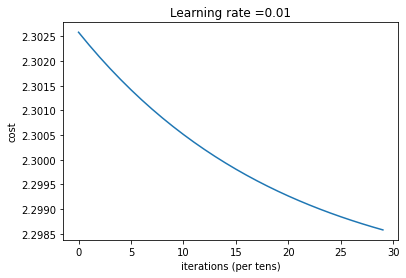

In [78]:
layers_dims = [784,13,21, 15,10]
x, y = x_train[0:784, 0:1024], y_train[0:10,0:1024]
# print_shape([x, y,x_train,y_train ])
Parameters, Cost, yhat = L_layer_model(x, y, layers_dims, learning_rate = 0.01, num_iterations = 3000, print_cost=True)

In [82]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    #(≈ 2 lines of code)
    # A2, cache = ...
    # predictions = ...
    # YOUR CODE STARTS HERE
    yhat, cache = L_model_forward(X, parameters)
    predictions = (yhat > 0.5)
    
    
    # YOUR CODE ENDS HERE
    
    return predictions


In [83]:
def accuracy_calculator(prediction, Yhat):
    diff = prediction - Yhat
    count = np.count_nonzero(diff)
    total = prediction.shape[0] * prediction.shape[1]
    percentage = 100 - (count / total * 100)
    print("accuracy from accuracy calculator =" + str(percentage) + "%")
    return percentage
    
    

In [84]:
def accuracy(Y_predict,Y_label):
  m=Y_label.shape[1]
  truee=0
  Y_p=np.zeros((10,m))

  for i in  range(m):
    max_index=np.argmax(Y_predict[:,i:i+1],axis=0)
    Y_p[max_index,i]=1.0
    if (np.array_equal(Y_p[:,i:i+1],Y_label[:,i:i+1])):
      truee+=1

  print("accuracy: ",(truee/m)*100)

In [85]:
predictions = predict(Parameters, x_train)
print("Training accuracy:")
accuracy_calculator(predictions, y_train)
accuracy(predictions, y_train)
print("train accuracy: {} %".format(100 - np.mean(np.abs(predictions - y_train)) * 100))
predictions = predict(Parameters, x_test)
print("testing accuracy")
accuracy_calculator(predictions, y_test)
print("test accuracy: {} %".format(100 - np.mean(np.abs(predictions - y_test)) * 100))

Training accuracy:
accuracy from accuracy calculator =90.0%
accuracy:  9.871666666666666
train accuracy: 90.0 %
testing accuracy
accuracy from accuracy calculator =90.0%
test accuracy: 90.0 %
